In [1]:
import collections

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import contextlib

%matplotlib inline

In [2]:
tf.__version__

'0.9.0'

# Load MNIST

In [3]:
mnist = input_data.read_data_sets('mnist', one_hot=True)
image_size = 28 * 28
num_classes = 10
assert mnist.train.images.shape[1] == image_size
assert mnist.train.labels.shape[1] == num_classes

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


# Linear Logistic Regression
References
- [MNIST For ML Beginners](https://www.tensorflow.org/versions/r0.9/tutorials/mnist/beginners/index.html)
- [L2 Reguralization example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/image/mnist/convolutional.py)
  - How is `tf.nn.l2_loss` different from square and reduce_sum?

In [4]:
def RunLogsticRegression(learning_rate = 0.05,
                         batch_size = 8,
                         steps = 200 * 1000,
                         sample = 1000,
                         l2_regularization_strength = 0.0):
    train_losses = []
    validation_losses = []
    step_records = []

    @contextlib.contextmanager
    def show_graph():
        try:
            yield
        finally:
            plt.plot(step_records, train_losses)
            plt.plot(step_records, validation_losses)
            plt.show()

    graph = tf.Graph()
    sess = tf.Session(graph=graph)
    with graph.as_default():
        inputs = tf.placeholder(tf.float32, [None, image_size])
        labels = tf.placeholder(tf.float32, [None, num_classes])

        weights = tf.Variable(tf.truncated_normal([image_size, num_classes], stddev=1), name='a')
        biases = tf.Variable(tf.constant(0.1, shape=[num_classes]))
        logits = tf.matmul(inputs, weights) + biases
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))
        
        loss = cross_entropy
        if l2_regularization_strength > 0:
            regularizer = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases)
            loss += l2_regularization_strength * regularizer

        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

        correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

        init_variables = tf.initialize_all_variables()

    with show_graph(), sess.as_default():
        init_variables.run()
        for step in xrange(steps):
            batch_input, batch_label = mnist.train.next_batch(batch_size)
            sess.run(train_step, {inputs: batch_input, labels: batch_label})
            if step % sample == 0:
                batch_entropy, batch_accuracy = sess.run((cross_entropy, accuracy),
                                                         {inputs: batch_input, labels: batch_label})
                train_entropy, train_accuracy = sess.run((cross_entropy, accuracy),
                                                         {inputs: mnist.train.images, labels: mnist.train.labels})
                validation_entropy, validation_accuracy = sess.run((cross_entropy, accuracy),
                                                                   {inputs: mnist.validation.images, labels: mnist.validation.labels})
                print 'step: %d, batch loss: %f, train loss: %f, train accuracy: %.2f%%, validation loss: %f, validation accuracy: %.2f%%' % (
                    step, batch_entropy, train_entropy, 100. * train_accuracy, validation_entropy, 100. * validation_accuracy)
                if step > 10000:
                    step_records.append(step)
                    train_losses.append(train_entropy)
                    validation_losses.append(validation_entropy)

step: 0, batch loss: 11.875708, train loss: 12.878407, train accuracy: 6.91%, validation loss: 13.036783, validation accuracy: 7.24%
step: 1000, batch loss: 1.344817, train loss: 1.242410, train accuracy: 73.33%, validation loss: 1.190305, validation accuracy: 74.60%
step: 2000, batch loss: 0.971194, train loss: 0.914998, train accuracy: 80.01%, validation loss: 0.888195, validation accuracy: 81.42%
step: 3000, batch loss: 0.940881, train loss: 0.773140, train accuracy: 82.70%, validation loss: 0.756958, validation accuracy: 83.86%
step: 4000, batch loss: 0.229205, train loss: 0.721512, train accuracy: 83.65%, validation loss: 0.706955, validation accuracy: 84.42%
step: 5000, batch loss: 1.263245, train loss: 0.653587, train accuracy: 84.86%, validation loss: 0.651343, validation accuracy: 85.58%
step: 6000, batch loss: 0.097111, train loss: 0.596512, train accuracy: 85.96%, validation loss: 0.593828, validation accuracy: 86.40%
step: 7000, batch loss: 1.366979, train loss: 0.595970, t

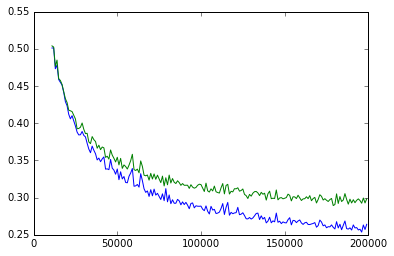

In [5]:
RunLogsticRegression()

step: 0, batch loss: 10.017137, train loss: 13.211545, train accuracy: 10.55%, validation loss: 13.283140, validation accuracy: 10.70%
step: 1000, batch loss: 2.636510, train loss: 2.020568, train accuracy: 60.73%, validation loss: 1.991344, validation accuracy: 60.78%
step: 2000, batch loss: 3.190465, train loss: 1.399799, train accuracy: 70.92%, validation loss: 1.355783, validation accuracy: 71.98%
step: 3000, batch loss: 0.751365, train loss: 1.131583, train accuracy: 75.76%, validation loss: 1.087955, validation accuracy: 77.00%
step: 4000, batch loss: 0.036782, train loss: 0.983232, train accuracy: 78.61%, validation loss: 0.940905, validation accuracy: 79.70%
step: 5000, batch loss: 1.104783, train loss: 0.890700, train accuracy: 80.35%, validation loss: 0.848130, validation accuracy: 81.50%
step: 6000, batch loss: 0.731043, train loss: 0.826056, train accuracy: 81.77%, validation loss: 0.790685, validation accuracy: 82.94%
step: 7000, batch loss: 0.304695, train loss: 0.773462,

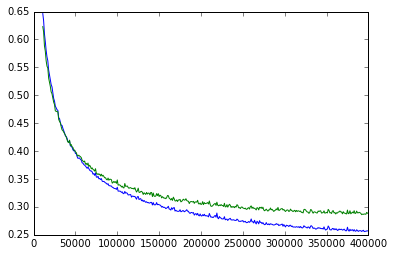

In [6]:
RunLogsticRegression(
    learning_rate=0.02,
    steps = 400 * 1000,
    l2_regularization_strength=0.1,
)

# Neural Network with LeRU and softmax

In [7]:
def RunNeuralNetwork(learning_rate = 0.01,
                     batch_size = 16,
                     steps = 100 * 1000,
                     sample = 5000,
                     dropout_keep_prob = 1.0,
                     hidden_sizes = [100, 75, 50]):
    graph = tf.Graph()
    sess = tf.Session(graph=graph)

    with graph.as_default():
        inputs = tf.placeholder(tf.float32, [None, image_size])
        labels = tf.placeholder(tf.float32, [None, num_classes])
        keep_prob = tf.placeholder(tf.float32)

        layer = inputs
        for hidden_size in hidden_sizes:
            input_size = layer.get_shape()[1].value
            weights = tf.Variable(tf.truncated_normal([input_size, hidden_size], stddev=0.1))
            biases = tf.Variable(tf.constant(0.1, shape=[hidden_size]))
            layer = tf.nn.relu(tf.matmul(layer, weights) + biases)
            if dropout_keep_prob < 1.0:
                layer = tf.nn.dropout(layer, keep_prob)

        input_size = layer.get_shape()[1].value
        weights = tf.Variable(tf.truncated_normal([input_size, num_classes], stddev=0.1))
        biases = tf.Variable(tf.constant(0.1, shape=[num_classes]))
        logits = tf.matmul(layer, weights) + biases
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))

        # train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)    
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
        
        correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

        # This must be called after all Variable definitions.
        init_variables = tf.initialize_all_variables()

    step_records = []
    train_losses = []
    validation_losses = []
    @contextlib.contextmanager
    def show_graph():
        try:
            yield
        finally:
            plt.plot(step_records, train_losses)
            plt.plot(step_records, validation_losses)
            plt.show()

    with show_graph(), sess.as_default():
        init_variables.run()

        for step in xrange(steps):
            batch_input, batch_label = mnist.train.next_batch(batch_size)
            sess.run(train_step, {inputs: batch_input, labels: batch_label, keep_prob: dropout_keep_prob})
            if step % sample == 0 or step == steps - 1:
                batch_entropy = sess.run(
                    cross_entropy,
                    {inputs: mnist.validation.images, labels: mnist.validation.labels, keep_prob: 1.0}
                )
                train_entropy, train_accuracy = sess.run(
                    (cross_entropy, accuracy),
                    {inputs: mnist.train.images, labels: mnist.train.labels, keep_prob: 1.0}
                )
                validation_entropy, validation_accuracy = sess.run(
                    (cross_entropy, accuracy),
                    {inputs: mnist.validation.images, labels: mnist.validation.labels, keep_prob: 1.0}
                )
                print 'step: %d, batch loss: %.4f, train loss: %f, train accuracy: %.2f%%, validation loss: %.4f, validation accuracy: %.2f%%' % (
                    step, batch_entropy, train_entropy, 100. * train_accuracy, validation_entropy, 100. * validation_accuracy)
                if train_entropy < 0.5:
                    step_records.append(step)
                    train_losses.append(train_entropy)
                    validation_losses.append(validation_entropy)

step: 0, batch loss: 2.3219, train loss: 2.322336, train accuracy: 12.45%, validation loss: 2.3219, validation accuracy: 13.00%
step: 5000, batch loss: 0.2438, train loss: 0.256495, train accuracy: 92.61%, validation loss: 0.2438, validation accuracy: 93.08%
step: 10000, batch loss: 0.1753, train loss: 0.181387, train accuracy: 94.80%, validation loss: 0.1753, validation accuracy: 95.10%
step: 15000, batch loss: 0.1476, train loss: 0.143394, train accuracy: 95.81%, validation loss: 0.1476, validation accuracy: 95.78%
step: 20000, batch loss: 0.1225, train loss: 0.112974, train accuracy: 96.81%, validation loss: 0.1225, validation accuracy: 96.74%
step: 25000, batch loss: 0.1177, train loss: 0.103648, train accuracy: 96.87%, validation loss: 0.1177, validation accuracy: 96.64%
step: 30000, batch loss: 0.1114, train loss: 0.086415, train accuracy: 97.38%, validation loss: 0.1114, validation accuracy: 96.86%
step: 35000, batch loss: 0.1030, train loss: 0.075174, train accuracy: 97.80%, va

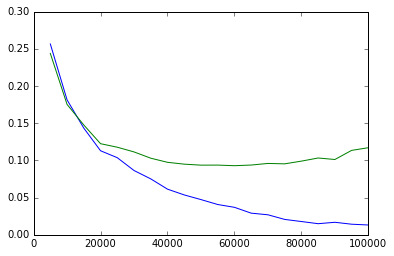

In [8]:
RunNeuralNetwork()

step: 0, batch loss: 2.3943, train loss: 2.388436, train accuracy: 12.43%, validation loss: 2.3943, validation accuracy: 11.94%
step: 5000, batch loss: 0.3721, train loss: 0.377826, train accuracy: 89.47%, validation loss: 0.3721, validation accuracy: 89.84%
step: 10000, batch loss: 0.2324, train loss: 0.236560, train accuracy: 92.91%, validation loss: 0.2324, validation accuracy: 93.30%
step: 15000, batch loss: 0.1879, train loss: 0.184888, train accuracy: 94.52%, validation loss: 0.1879, validation accuracy: 94.66%
step: 20000, batch loss: 0.1626, train loss: 0.155641, train accuracy: 95.42%, validation loss: 0.1626, validation accuracy: 95.36%
step: 25000, batch loss: 0.1391, train loss: 0.130095, train accuracy: 96.12%, validation loss: 0.1391, validation accuracy: 96.28%
step: 30000, batch loss: 0.1258, train loss: 0.113720, train accuracy: 96.57%, validation loss: 0.1258, validation accuracy: 96.42%
step: 35000, batch loss: 0.1218, train loss: 0.101529, train accuracy: 97.02%, va

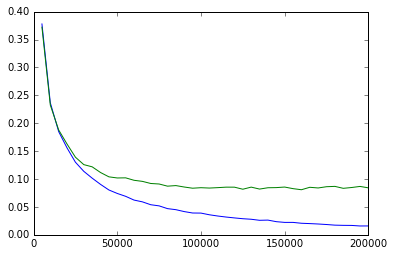

In [10]:
RunNeuralNetwork(
    dropout_keep_prob=0.5,
    steps = 200 * 1000,
    hidden_sizes = [200, 150, 100],
)